# Exploration of San Francisco Crime Data
By Chuck Bolin

https://www.kaggle.com/c/sf-crime/data



## Imports and Loading Data

In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
from math import sqrt
from math import floor

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [7]:
# Load training and testing data
train = pd.read_csv("data/train.csv",parse_dates = ['Dates'], date_parser = pd.datetools.to_datetime)
test = pd.read_csv("data/test.csv",parse_dates = ['Dates'], date_parser = pd.datetools.to_datetime)

## Feature Engineering

In [8]:
# Converts minutes to a categorical value
# E.g. step = 15, 0 to 4
def getMinCat(lst):
    category = lst
    for i in range(len(category)):
        if lst[i] < 15:
            category[i] = 1
        elif lst[i] < 30:
            category[i] = 2
        elif lst[i] < 45:
            category[i] = 3
        else:
            category[i] = 4
    
    return category

# Converts lat/long to a grid value, 0 is out of bounds
def getGridLoc(x, y, gridSize):
    gridLoc = [0] * len(x)
    lowerX = -122.53
    upperX = -122.37
    lowerY = 37.72
    upperY = 37.83
    deltaX = (upperX - lowerX)/gridSize
    deltaY = (upperY - lowerY)/gridSize
    
    for i in range(len(x)):
        if x[i] < lowerX or x[i] > upperX:
            gridLoc[i] = 0 #.append(0)
        elif y[i] < lowerY or y[i] > upperY:
            gridLoc[i] = 0 #.append(0)
        else:        
            row = int((y[i] - lowerY)/deltaY)
            col = int((x[i] - lowerX)/deltaX)
            gridLoc[i] = ((row * gridSize) + col) + 1
    return  gridLoc         

# Borrowed from Matt B.
# Add date time specific columns
def dateAttributes(df):
    df = df.copy()
    df['Year'] = pd.DatetimeIndex(df['Dates']).year
    df['Month'] = pd.DatetimeIndex(df['Dates']).month
    df['Day'] = pd.DatetimeIndex(df['Dates']).day
    df['Hour'] = pd.DatetimeIndex(df['Dates']).hour
    df['Minute'] = pd.DatetimeIndex(df['Dates']).minute
    df['MinuteCat'] = getMinCat(pd.DatetimeIndex(df['Dates']).minute) # quarter hour 1,2,3,4
    df['GridLoc'] = getGridLoc(df['X'], df['Y'], 4)
    return df

# Add additional columns
train = dateAttributes(train)
test = dateAttributes(test)

train['DayOfWeek'] = train['DayOfWeek'].astype('category').cat.codes
train['PdDistrict'] = train['PdDistrict'].astype('category').cat.codes
test['DayOfWeek'] = test['DayOfWeek'].astype('category').cat.codes
test['PdDistrict'] = test['PdDistrict'].astype('category').cat.codes


## Data Exploration 1

In [9]:
print "Data Info\n"
print "Train Shape: ", train.shape
print train.columns.values
print

print "Test Shape:  ", test.shape
print test.columns.values
print

# Create list of unique crime categories (39)
uniq_cat_train = np.sort(train['Category'].unique())
print "Number of categories: ", len(uniq_cat_train), "\n"
print train['Category'].unique()
print

print "Unique Addresses:", len(train['Address'].unique())
print

uniq_district_train = np.sort(train['PdDistrict'].unique())
print "Unique PdDistrict:", len(uniq_district_train)
print
print uniq_district_train
print

# Create list of Years
uniq_years = np.sort(train['Year'].unique())
uniq_years_str = []
for i in range(len(uniq_years)):
    uniq_years_str.append("" + str(uniq_years[i]) + "")

print "Unique Years: ", uniq_years
print uniq_years_str

print train.head()
print train.tail()

Data Info

Train Shape:  (878049, 16)
['Dates' 'Category' 'Descript' 'DayOfWeek' 'PdDistrict' 'Resolution'
 'Address' 'X' 'Y' 'Year' 'Month' 'Day' 'Hour' 'Minute' 'MinuteCat'
 'GridLoc']

Test Shape:   (884262, 14)
['Id' 'Dates' 'DayOfWeek' 'PdDistrict' 'Address' 'X' 'Y' 'Year' 'Month'
 'Day' 'Hour' 'Minute' 'MinuteCat' 'GridLoc']

Number of categories:  39 

['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']

Unique Addresses: 23228

Unique Pd

Initial exploration lead to feature addition of date time components. 'MinuteCat', values 1 through 4 correspond to quarter hours. The following questions are further investigated.
* Number of crimes per district
* Number of crimes per year
* Top 10 categories of crime for each year




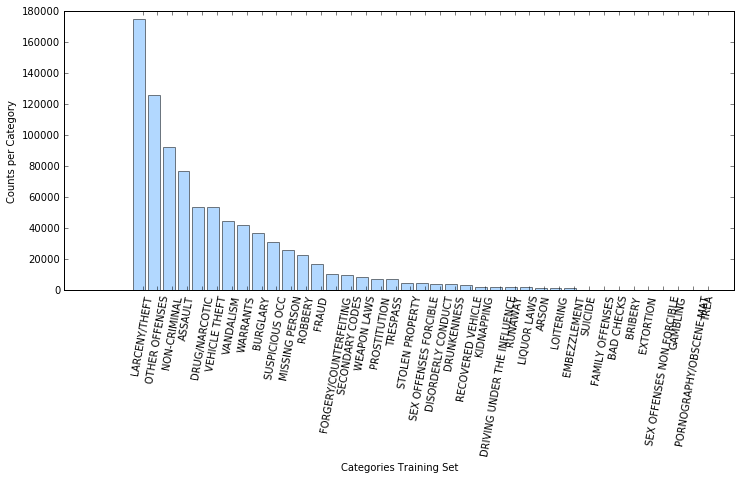

In [182]:
# Create data frame df containing categories, counts, and percentage of total
df = pd.DataFrame()

# Construct data frame, rows = categories, columns equal counts by year
for i in range(len(uniq_cat_train)):
    total_count = len(train[(train['Category'] == uniq_cat_train[i])]) # Subset of data matching category
    year_count = []
    for j in range(len(uniq_years)):
        year_counts = int(len(train[(train['Category'] == uniq_cat_train[i]) & (train['Year'] == uniq_years[j])])) # Subset of data matching category
        year_count.append(year_counts)
        
    df = df.append({'Cat': uniq_cat_train[i],
                    '2003': year_count[0], '2004': year_count[1],'2005': year_count[2], '2006': year_count[3],
                    '2007': year_count[4], '2008': year_count[5],'2009': year_count[6], '2010': year_count[7],
                    '2011': year_count[8], '2012': year_count[8],'2013': year_count[10], '2014': year_count[11],
                    '2015': year_count[12],'Count': total_count},ignore_index=True)    


# Sort categories and display in descending order 
result = df.sort(['Count'], ascending=[0])
# print result

# Plot as pareto chart
n_groups = 39
index = np.arange(n_groups)
plt.figure(figsize=(12,5))
plt.bar(range(len(result)), result['Count'], alpha = 0.5, color='#66b3ff', align='center', label='Count')
plt.ylabel('Counts per Category')
plt.xlabel('Categories Training Set')
bar_width = 0.25
plt.xticks(index + bar_width, result['Cat'], rotation=80)

plt.show()


## Creating Model from Category Probabilities

Probabilities for one category is applied to all observations regardless of year.

In [ ]:
## Same model applied to all years
# Create submission report using same probabilities per category for each observation
# Submission1.csv
import csv

# Get list of categories - unique
cats = np.sort(train['Category'].unique())

# construct file header
header = "id,"
for i in range(len(cats)):
    if i < len(cats) - 1:
        header += cats[i] + ","
    else:
        header += cats[i]
print header

# construct list of probabilities
total = float(len(train))

values = []
for i in range(0,39):
    value = float(len(train[train['Category'] == cats[i]]))
    values.append(value/total)

# format probabilities    
stem = ""
for i in range(0,39):
    if i < len(values) - 1:
        stem += "{0:.6f}".format(round(values[i],6)) + ","
    else:
        stem += "{0:.6f}".format(round(values[i],6))

# build submission file
text_file = open('data/submission2a.csv', "w")
text_file.write(header + "\n")
for idx in range(0,3): #len(test)):
    text_file.write(str(idx) + "," + stem + "\n")
text_file.close()


## Creating Model from Category Probabilities

Probabilities for one category is applied to all observations of that year. They various from year to year.

In [ ]:
## Applies different set of probabilities based upon exact year
# Create submission report using same probabilities per category for each observation
# Submission1.csv
import csv

# Get list of categories - unique
cats = np.sort(train['Category'].unique())

# construct file header
header = "id,"
for i in range(len(cats)):
    if i < len(cats) - 1:
        header += cats[i] + ","
    else:
        header += cats[i]
print header

# construct list of probabilities

stems = {} # dictionary to store year and a stem (probabilities comma delimite)

for m in range(len(uniq_years)):
    total = float(len(train[train['Year'] == uniq_years[m]]))
    values = []
    for i in range(0,39):
        value = float(len(train[(train['Year'] == uniq_years[m]) & (train['Category'] == cats[i])]))
        values.append(value/total)

    # format probabilities    
    stem = ""
    for i in range(0,39):
        if i < len(values) - 1:
            stem += "{0:.6f}".format(round(values[i],6)) + ","
        else:
            stem += "{0:.6f}".format(round(values[i],6))
            
    stems[uniq_years[m]] = stem

# for i in range(len(uniq_years)):
#     print stems[uniq_years[i]]

# build submission file
text_file = open('data/submission3.csv', "w")
text_file.write(header + "\n")

for idx in range(len(test)):
    yr = test.iloc[idx,7]    
    text_file.write(str(idx) + "," + stems[yr] + "\n")
text_file.close()


In [ ]:
# for i in range(0,3):
# print test.columns.values
print test.iloc[0:3,7]
print test.iloc[2,7]

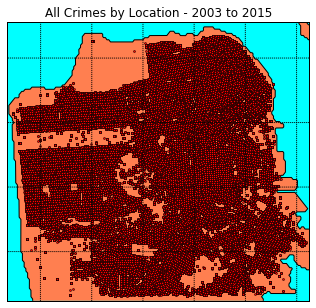

In [6]:
# Create a figure of size (i.e. pretty big)
fig = plt.figure(figsize=(10, 5)) #20,10))

# Create a map, using the Gall–Peters projection, 
map = Basemap(projection='tmerc', 
              resolution = 'f',  #f
              area_thresh = 0.1,
              lat_0=37.760, lon_0=-122.4425,
              width = 13000,
              height = 12000
             )

# Draw the map boundaries
map.drawmapboundary(fill_color='aqua')

# Fill the land with grey
map.fillcontinents(color = 'coral') #, lake_color='aqua')

# Draw the coastlines on the map
map.drawcoastlines()

# Define our longitude and latitude points
x,y = map(train['X'].values, train['Y'].values)

# Plot them using round markers of size 6
map.plot(x, y, 'ro', markersize=2)
map.drawmeridians(np.arange(-122.525, -122.375, 0.025))
map.drawparallels(np.arange(37.725, 37.825, 0.025))

# Show the map
plt.title("All Crimes by Location - 2003 to 2015")
plt.show()

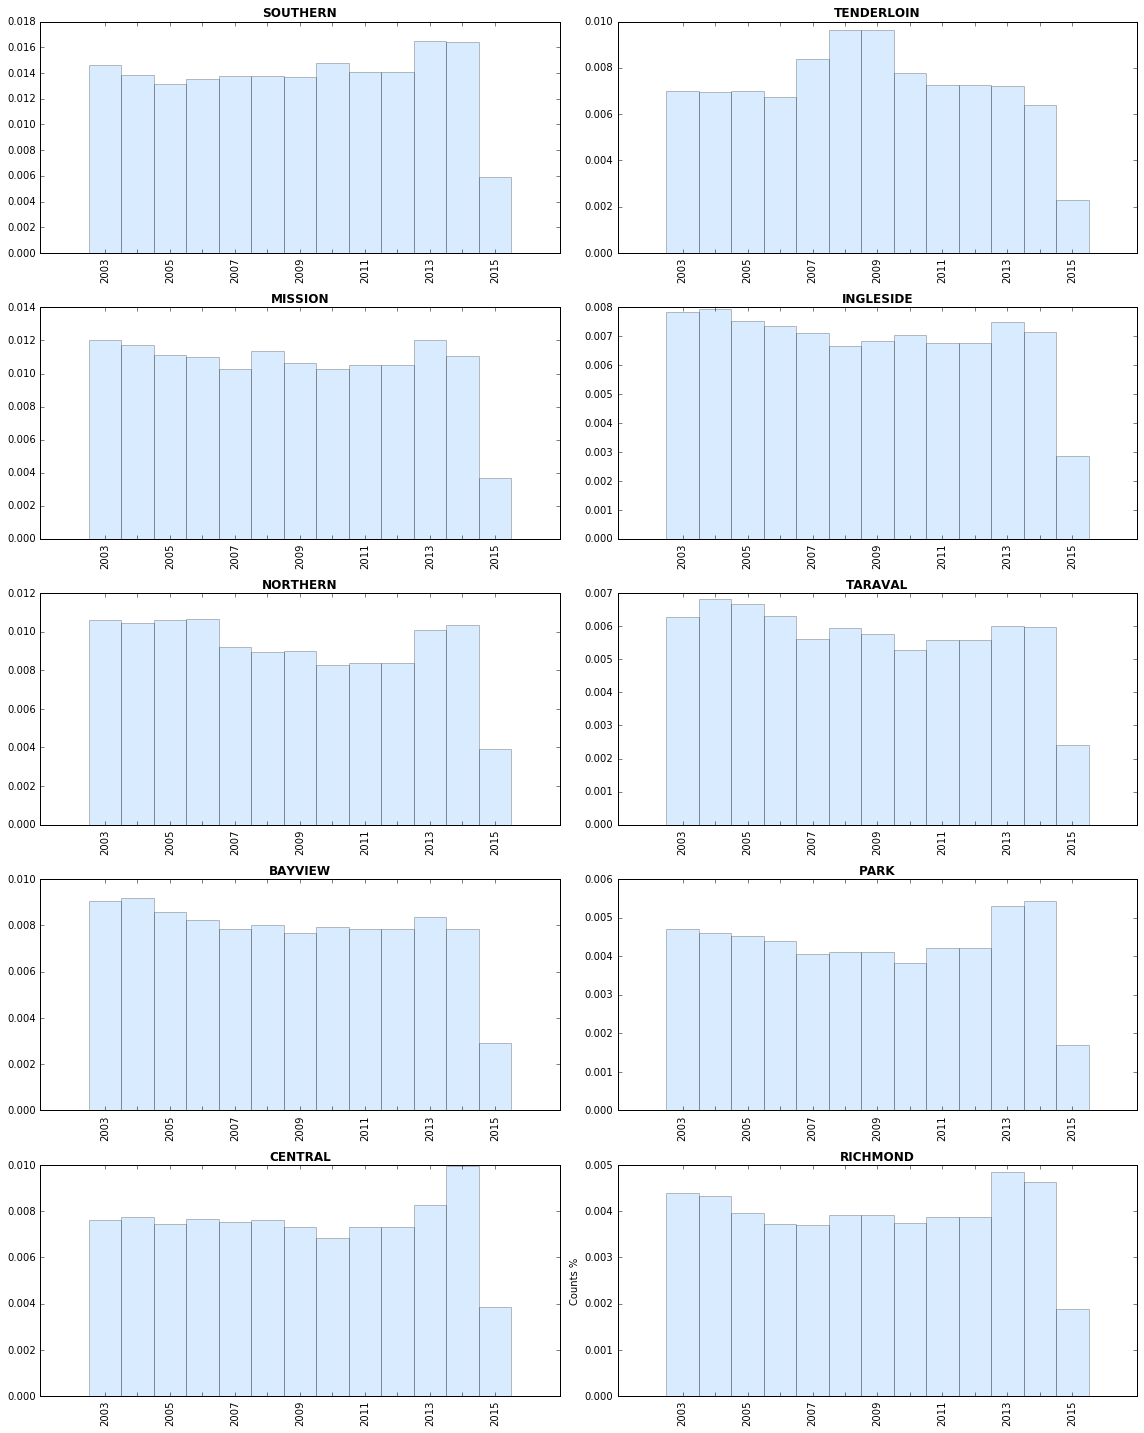

In [183]:
# print uniq_district_train
uniq_years_spaced = uniq_years_str
for i in range(len(uniq_years_str)):
    if i%2 == 1:
        uniq_years_spaced[i] = ''
        
# Create data frame df containing categories, counts, and percentage of total
df2 = pd.DataFrame()

# Construct data frame, rows = categories, columns equal counts by year
for i in range(len(uniq_district_train)):
    total_count = len(train[(train['PdDistrict'] == uniq_district_train[i])]) # Subset of data matching category
    year_count = []
    for j in range(len(uniq_years)):
        year_counts = int(len(train[(train['PdDistrict'] == uniq_district_train[i]) & (train['Year'] == uniq_years[j])])) # Subset of data matching category
        year_count.append(year_counts)
        
    df2 = df2.append({'District': uniq_district_train[i],
                    '2003': year_count[0], '2004': year_count[1],'2005': year_count[2], '2006': year_count[3],
                    '2007': year_count[4], '2008': year_count[5],'2009': year_count[6], '2010': year_count[7],
                    '2011': year_count[8], '2012': year_count[8],'2013': year_count[10], '2014': year_count[11],
                    '2015': year_count[12],'Count': total_count},ignore_index=True)    


# Sort categories and display in descending order 
result2 = df2.sort(['Count'], ascending=[0])
# print result2.head()

fig, ax = plt.subplots(5, 2)
fig.set_size_inches(16, 20)

for i in range(len(result2)):
    row = i%5
    col = (i-(i%5))/5

    values = result2.iloc[i,:].values[0:13] 
    total = result2.iloc[i,:].values[13] 
    category = result2.iloc[i,:].values[14] 
    valuesFrac = values/float(len(train))
    
    # Plot as pareto chart
    n_groups = 10
    index = np.arange(n_groups)
    ax[row, col].bar(range(len(valuesFrac)), valuesFrac,color='#66b3ff',width=1, alpha = 0.25, align='center', label='Count')
    ax[row, col].set_title(category, fontweight='bold')

    plt.ylabel('Counts %')
    plt.xlabel('Year')
    bar_width = 0.25
    ax[row, col].set_xticks(range(len(uniq_years)))
    ax[row, col].set_xticklabels(uniq_years_spaced, rotation=90)
    ax[row, col].set_xlabel("")

plt.tight_layout() 
plt.show()

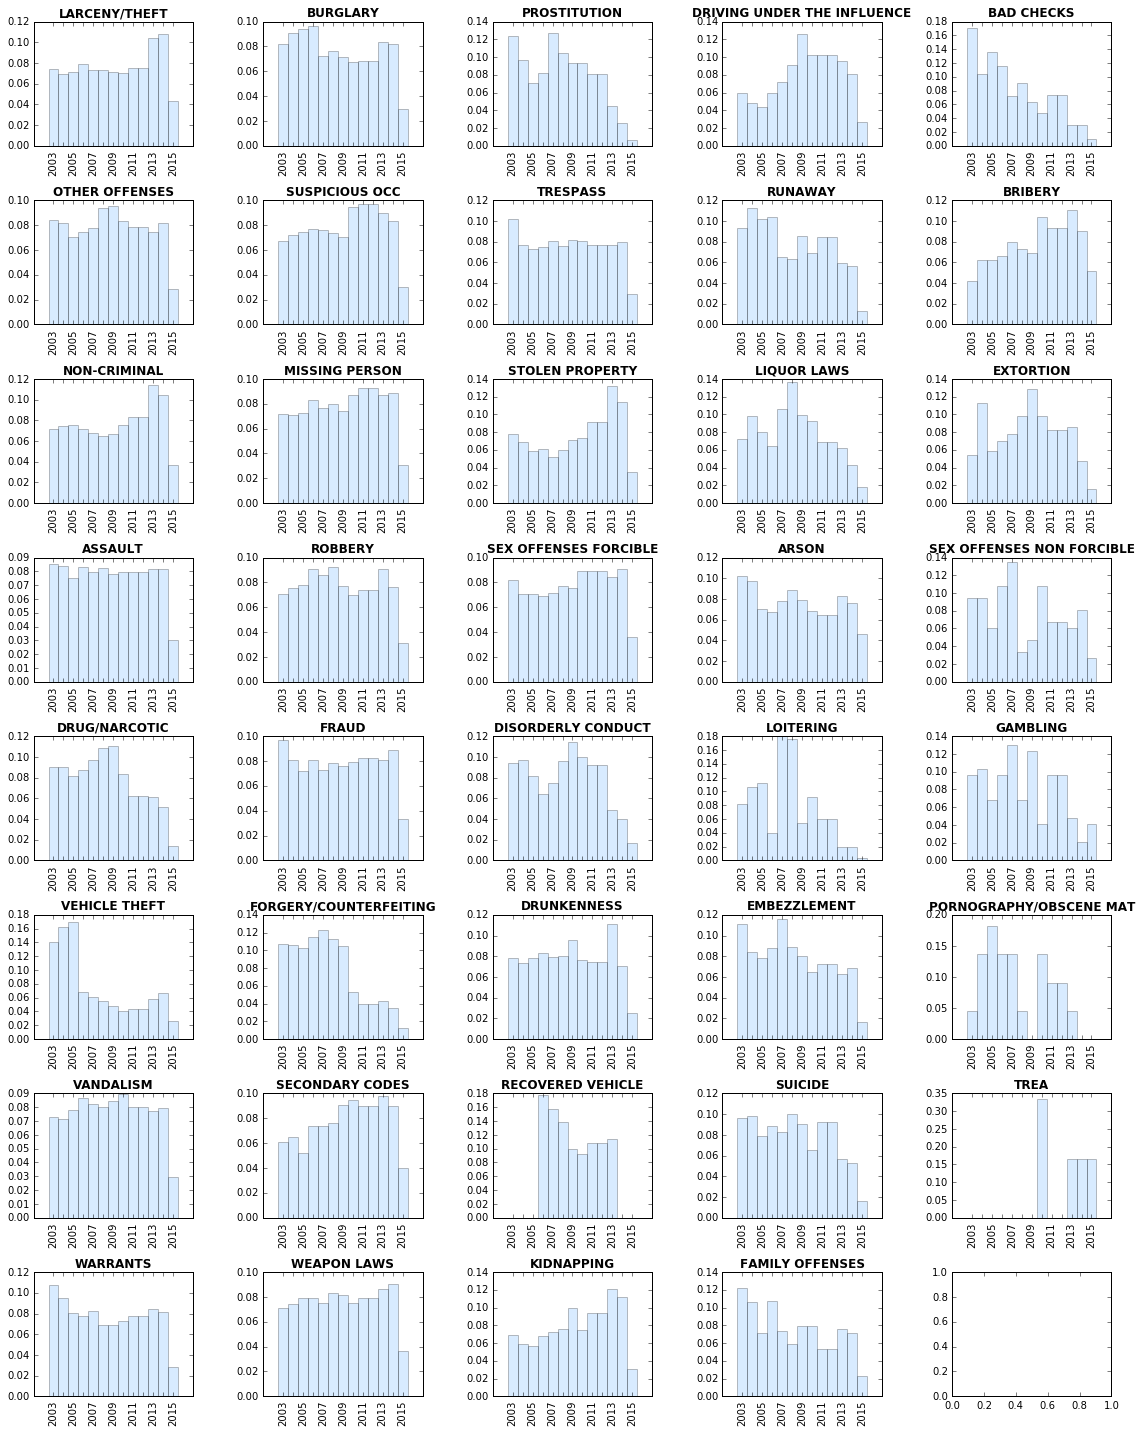

In [185]:
for i in range(len(uniq_years_str)):
    if i%2 == 1:
        uniq_years_spaced[i] = ''
    
fig, ax = plt.subplots(8, 5)
fig.set_size_inches(16, 20)
# fig.title('Categories of Crime from 2003 - 2015')

for i in range(len(result)):
    row = i%8
    col = (i-(i%8))/8

    values = result.iloc[i,:].values[0:13] 
    total = result.iloc[i,:].values[14] 
    category = result.iloc[i,:].values[13] 
    valuesFrac = values/total
    
    # Plot as pareto chart
    n_groups = 13
    index = np.arange(n_groups)
    ax[row, col].bar(range(len(valuesFrac)), valuesFrac,color='#66b3ff',width=1, alpha = 0.25, align='center', label='Count')
    ax[row, col].set_title(category, fontweight='bold')

    bar_width = 0.25
    ax[row, col].set_xticks(range(len(uniq_years)))
    ax[row, col].set_xticklabels(uniq_years_spaced, rotation=90)
    ax[row, col].set_xlabel("")

    
plt.tight_layout() 
plt.show()


# The following observations are made from the above data:
    * 2015 data is partial and should not be used to make any inferences
    * 'Other Offenses' are roughly consistent across all years (~ 8%)  
    

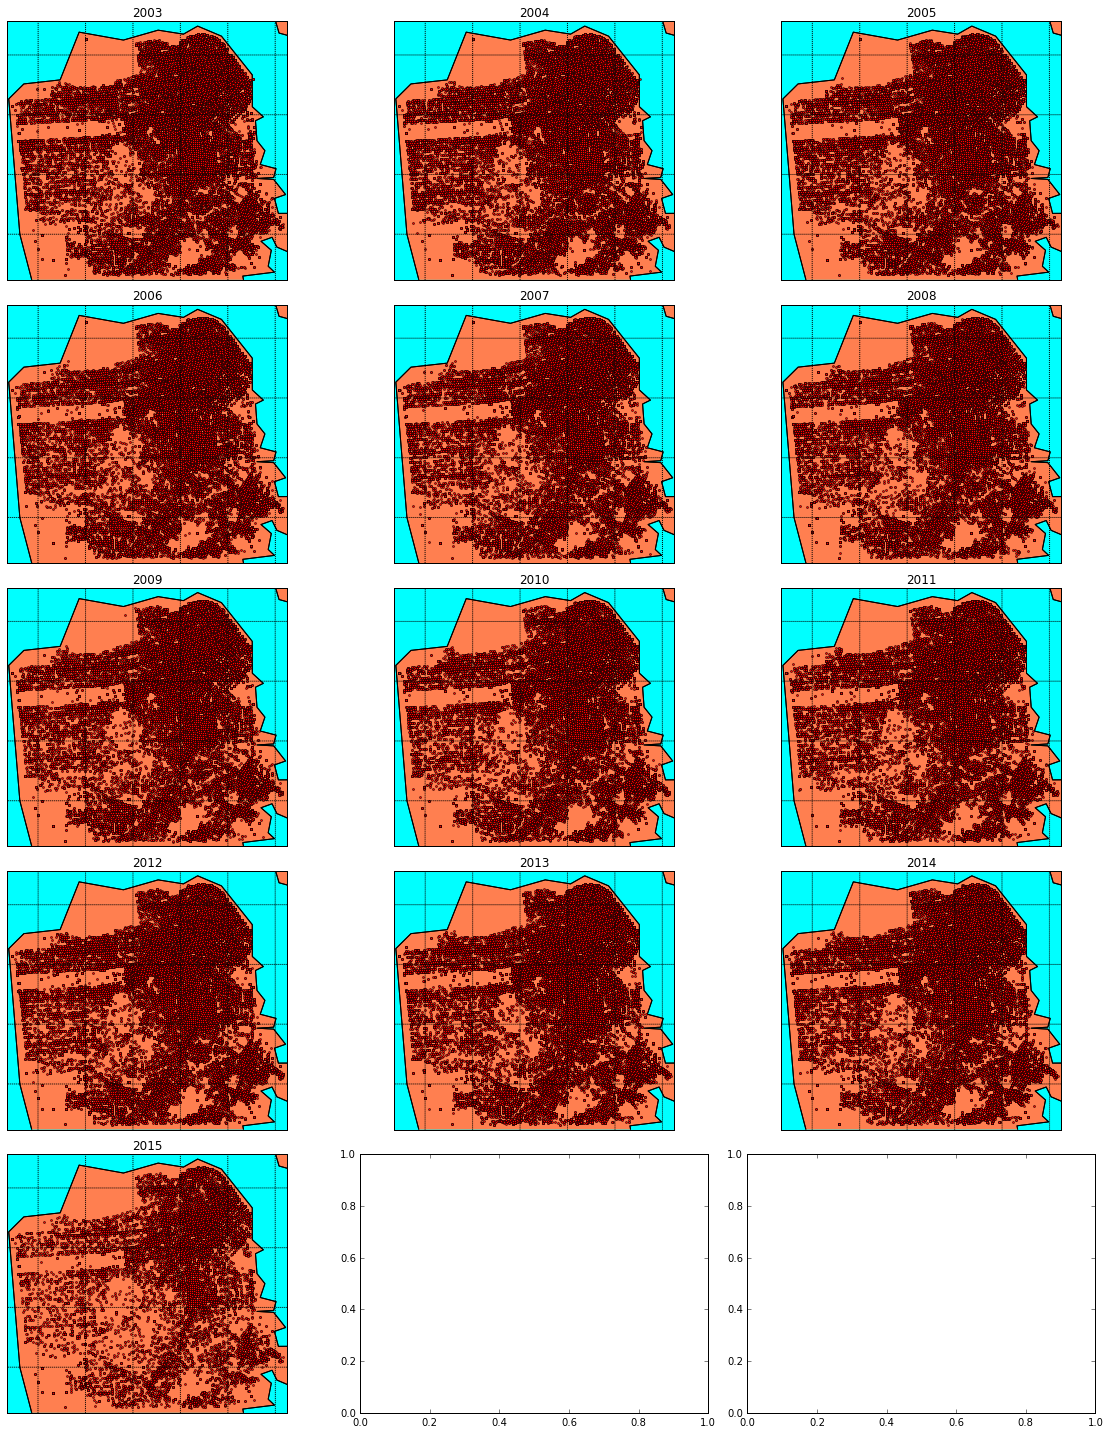

In [23]:
fig, axes = plt.subplots(nrows=5, ncols=3)
fig.set_size_inches(16, 20)

idx = 0

for ax in axes.flat:
    if idx < 13:    
        map_ax = Basemap(projection='tmerc',
                  ax=ax,
                  resolution = 'h',  #f, c, l, i
                  area_thresh = 0.1,
                  lat_0=37.760, lon_0=-122.4425,
                  width = 13000,
                  height = 12000)

        map_ax.drawcoastlines()
        map_ax.drawmapboundary(fill_color='aqua')
        map_ax.fillcontinents(color = 'coral') 
        map_ax.drawcoastlines()
        x, y = map(x = train[(train['Year'] == uniq_years[idx])]['X'].values, y = train[(train['Year'] == uniq_years[idx])]['Y'].values)
        map_ax.plot(x, y, 'ro', markersize=2)
        map_ax.drawmeridians(np.arange(-122.525, -122.375, 0.025))
        map_ax.drawparallels(np.arange(37.725, 37.825, 0.025))
        ax.set_title(uniq_years[idx])

    idx += 1
    
plt.tight_layout()    
plt.show()


## Classifier Throwing Errors

In [366]:

# target = train.iloc[:,1].astype('category')
# traindata = train.iloc[:,[3, 4, 9,10,11,12,14,15]]
# testdata = test.iloc[:,[0,2,3,7,8,9,10,12,13]]

# print traindata.head()
# print traindata.dtypes
# traindata['DayOfWeek'] = traindata['DayOfWeek'].astype('category')
# traindata['PdDistrict'] = traindata['PdDistrict'].astype('category')
# testdata['DayOfWeek'] = testdata['DayOfWeek'].astype('category')
# testdata['PdDistrict'] = testdata['PdDistrict'].astype('category')

# print traindata.dtypes
# print testdata.dtypes
# print target.dtypes

# print target.head()
# print traindata.head()
# print testdata.head()

# from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier(n_neighbors=3)
# neigh.fit(traindata, target) 
# neigh.predict([testdata])
# print(neigh.predict_proba([[0.9]]))

# Working Code Snippets Below (Panda)

In [139]:
## WORKS
# print result[result.columns.values]
# print result.iloc[0:4,]
# print result.iloc[0:4,[0, 13, 14]]
# print result.iloc[:,[0, 13, 14]]
# result.iloc[:,[0,14]]
# print result.iloc[:,[0,14]]
# print
# print result.iloc[:,[0]]
# print
# print result.iloc[:,[14]]
# print result.iloc[0:10,[0]].columns.values 
# print result.iloc[0:10,[0]] 
# for i in range(len(result)):
#     print result.iloc[i,:] # Reads one category counts for all years

# for i in range(1): #len(result)):
#     print result.iloc[i,:].values

# for i in range(1): #len(result)):
#     print result.iloc[i,:].values[0] 

# for i in range(1): #len(result)):
#     values = result.iloc[i,:].values[0:13] 
#     total = result.iloc[i,:].values[14] 
#     category = result.iloc[i,:].values[13] 
#     valuesFrac = values/total
#     print values
#     print category
#     print total
#     print valuesFrac
    
    
## Plotting
# for i in range(2): #len(result)):
#     values = result.iloc[i,:].values[0:13] 
#     total = result.iloc[i,:].values[14] 
#     category = result.iloc[i,:].values[13] 
#     valuesFrac = values/total
    
#     # Plot as pareto chart
#     n_groups = 13
#     index = np.arange(n_groups)
#     plt.figure(figsize=(12,5))
#     plt.bar(range(len(valuesFrac)), valuesFrac, alpha = 0.5, align='center', label='Count')
#     plt.title(category + " 2003-2015")
#     plt.ylabel('Counts %')
#     plt.xlabel('Year')
#     bar_width = 0.25
#     plt.xticks(index + bar_width, uniq_years, rotation=80)

#     plt.show()

## produce row and col from i
# for i in range(0,40):
#     print i, "Row:", i%10, "Col:", (i-(i%10))/10


# print train[(train['Category'] == uniq_cat_train[0]) & (train['Year'] == 2015)]
# print train[(train['Category'] == uniq_cat_train[0]) & (train['Year'] == 2015)]['X'],train[(train['Category'] == uniq_cat_train[0]) & (train['Year'] == 2015)]['Y']


# fig, axes = plt.subplots(nrows=4, ncols=3)
# for ax in axes.flat:
#     map_ax = Basemap(ax=ax)
#     map_ax.drawcoastlines()
# plt.show()
    
# plt.hist(tz, bins = 16)
# plt.title("Position Grid Histogram")
# plt.xlabel("Grid Position")
# plt.ylabel("Frequency")
# plt.show()    

#result = df.sort(['Count'], ascending=[0])
# print train.columns

# top10 = result['Cat'][0:13]
# lst = top10.tolist()

# print lst
# total = 0
# for i in range(len(lst)):
#     total += len(train[train['Category'] == lst[i]])
    
# print "total", total
# print "all", len(train)
# print "percent", 1.0 * total/len(train)

# other = len(train[train['Category'] == 'OTHER OFFENSES'])
# trn = len(train)
# print float(other)/trn

# other = len(train[train['Category'] == 'LARCENY/THEFT'])
# trn = len(train)
# print float(other)/trn